In [25]:
# https://keras.io/examples/vision/video_classification/

### Importing and preparing dataframe

In [26]:
!pip install -q git+https://github.com/tensorflow/docs

In [27]:
!rm -rf sample_data

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
datapath = '/content/gdrive/MyDrive/data/'

In [30]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [31]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [32]:
# open the file which have names of training videos
from os import listdir
from os.path import isfile,join

bc = [f for f in listdir(f"{datapath}goodtrain") if isfile(join(f"{datapath}goodtrain",f))]
sp = [f for f in listdir(f"{datapath}ShoulderPressGoodTrain") if isfile(join(f"{datapath}ShoulderPressGoodTrain",f))]
allvideos = bc+sp

videoclass = ['bicep_curl' for _ in range(len(bc))] + ['shoulder_press' for _ in range(len(sp))]

# creating a dataframe having video names
train = pd.DataFrame({'video_name':allvideos})
train['class'] = videoclass

print(train)

           video_name           class
0        Good PY2.mp4      bicep_curl
1       ry_good_9.MOV      bicep_curl
2        Good PY5.mp4      bicep_curl
3       ry_good_1.MOV      bicep_curl
4        Good PY1.mp4      bicep_curl
..                ...             ...
81  SPDiffAngPY13.mp4  shoulder_press
82       IMG_8661.MOV  shoulder_press
83   SPDiffAngPY3.mp4  shoulder_press
84   SPDiffAngPY2.mp4  shoulder_press
85  SPDiffAngPY17.mp4  shoulder_press

[86 rows x 2 columns]


In [33]:
# open the .txt file which have names of test videos
from os import listdir
from os.path import isfile,join

bctest = [f for f in listdir(f"{datapath}goodtest") if isfile(join(f"{datapath}goodtest",f))]
sptest = [f for f in listdir(f"{datapath}ShoulderPressGoodTest") if isfile(join(f"{datapath}ShoulderPressGoodTest",f))]
alltest = bctest+sptest

testclass = ['bicep_curl' for _ in range(len(bctest))] + ['shoulder_press' for _ in range(len(sptest))]

# creating a dataframe having video names
test = pd.DataFrame({'video_name':alltest})
test['class'] = testclass

print(test)

       video_name           class
0      Good 3.mp3      bicep_curl
1      Good 6.mov      bicep_curl
2      Good 1.mov      bicep_curl
3      Good 8.mov      bicep_curl
4     Good 10.mov      bicep_curl
5     Good 12.mov      bicep_curl
6     Good 11.mov      bicep_curl
7     Good 13.mov      bicep_curl
8      Good 4.mov      bicep_curl
9      Good 2.mov      bicep_curl
10     Good 9.mov      bicep_curl
11     Good 7.mov      bicep_curl
12     Good 3.mov      bicep_curl
13  SP good 3.mov  shoulder_press
14  SP good 1.mov  shoulder_press
15  SP good 2.mov  shoulder_press


### Model Training

In [34]:
def load_video(path, i, max_frames=0):
    if path == "train":
        videoname = train['video_name'][i]
        videoclass = train['class'][i]
        if videoclass == "bicep_curl":
          videotype = "goodT"
        elif videoclass == "shoulder_press":
          videotype = "ShoulderPressGoodT"
        video = datapath+videotype+"rain/"+videoname

    elif path == "test":
        videoname = test['video_name'][i]
        videoclass = test['class'][i]
        if videoclass == "bicep_curl":
          videotype = "goodT"
        elif videoclass == "shoulder_press":
          videotype = "ShoulderPressGoodT"
        video = datapath+videotype+"est/"+videoname
    cap = cv2.VideoCapture(video)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frameID = cap.get(1)
            if (frameID%2==0):
                frame = cv2.resize(frame, (224, 224))
                frames.append(frame)
            # storing the frames in a new folder named train_1
            # filename = f"{path}_1/{train['video_name'][i]}_frame{frameID/2}_{train['class'][i]}.jpg"
            # cv2.imwrite(filename, frame)
            # if len(frames) == max_frames:
            #     break
    finally:
        cap.release()
    return np.array(frames)

In [35]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


In [36]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train['class'])
)
print(label_processor.get_vocabulary())

['bicep_curl', 'shoulder_press']


In [37]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        # print(os.path.join(datapath, "bad"+ root_dir, path))
        frames = load_video(root_dir, idx)
        # frames2 = load_video(os.path.join(datapath, "bad"+root_dir, path), idx)
        frames = frames[None, ...]
        # print(frames)

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train, "train")
test_data, test_labels = prepare_all_videos(test, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (86, 20, 2048)
Frame masks in train set: (86, 20)


In [38]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()


Epoch 1/10
1/2 [==============>...............] - ETA: 7s - loss: 0.7272 - accuracy: 0.5625
Epoch 00001: val_loss improved from inf to 0.70219, saving model to /tmp/video_classifier
2/2 [==============================] - 10s 3s/step - loss: 0.7120 - accuracy: 0.3333 - val_loss: 0.7022 - val_accuracy: 0.0000e+00
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6938 - accuracy: 0.1250
Epoch 00002: val_loss improved from 0.70219 to 0.69267, saving model to /tmp/video_classifier
2/2 [==============================] - 0s 98ms/step - loss: 0.6925 - accuracy: 0.4500 - val_loss: 0.6927 - val_accuracy: 0.6154
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6946 - accuracy: 0.7188
Epoch 00003: val_loss improved from 0.69267 to 0.67632, saving model to /tmp/video_classifier
2/2 [==============================] - 0s 88ms/step - loss: 0.7051 - accuracy: 0.7500 - val_loss: 0.6763 - val_accuracy: 1.0000
Epoch 4/10
1/2 [==============>...............] - ETA: 0s -

### Model Evaluation

In [56]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(i,video):
    predicted_label = None
    predicted_prob = 0
    class_vocab = label_processor.get_vocabulary()

    frames = load_video("test", i)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
        if probabilities[i] > predicted_prob:
          predicted_prob = probabilities[i]
          predicted_label = class_vocab[i]
    
    return frames,video,predicted_prob,predicted_label


for idx, video in enumerate(test["video_name"].values.tolist()):
    print(f"Test video path: {video}")
    test_frames,_,_,_ = sequence_prediction(idx,video)

Test video path: Good 3.mp3
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 6.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 1.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 8.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 10.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 12.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 11.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 13.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 4.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 2.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 9.mov
  bicep_curl: 50.69%
  shoulder_press: 49.31%
bicep_curl
Test video path: Good 7.mov
  bicep_curl: 50.69%
  shoulder_p

## Adding Pengyu's classifier here

In [40]:
import matplotlib.pyplot as plt
import numpy as numpy
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

train_data = pd.read_csv('mean_variance.csv') # Load training data
test_data = pd.read_csv('mean_variance_test.csv') # Load test data
all_data = pd.concat([train_data,test_data])
print(all_data)



##normalise data / scaling / standard scaling 

                   file  r_arm_mean  ...  l_hip_variance  class
0   20211024_221837.mp4  145.936091  ...        6.381162      0
1   20211024_221843.mp4  146.998889  ...       36.845617      0
2   20211024_221849.mp4  132.311392  ...        6.705885      0
3   20211024_221854.mp4  129.495333  ...        3.407046      0
4   20211024_221859.mp4  144.987807  ...       27.398339      0
..                  ...         ...  ...             ...    ...
20           Good 4.mov   89.245071  ...      534.946483      1
21           Good 6.mov  233.412435  ...        7.091592      1
22           Good 7.mov  256.786654  ...        5.797683      1
23           Good 8.mov  245.501719  ...       92.369416      1
24           Good 9.mov  108.855380  ...      544.512392      1

[98 rows x 14 columns]


In [41]:
# Use 

# Split into training data for X_train,X_test,y_train,y_test
# X_train = train_data.drop(['file','class'],1)
# y_train = train_data['class']

# X_test = test_data.drop(['file','class'],1)
# y_test = test_data['class']

# use train_test_split
#X_train,X_test,y_train,y_test = train_test_split(train_data.drop(['file','class'],1),train_data['class'],shuffle=True,test_size=0.1)
#print(X_train,X_test,y_train,y_test)

# Use 

# Split into training data for X_train,X_test,y_train,y_test
X_train = train_data.drop(['file','class'],1)
y_train = train_data['class']

X_test = test_data.drop(['file','class'],1)
y_test = test_data['class']


print (X_train)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
print (X_train)

# from sklearn import preprocessing

# X_train = preprocessing.normalize(X_train)
# X_test =  preprocessing.normalize(X_test)

# print (X_train)



# use train_test_split
# X_train,X_test,y_train,y_test = train_test_split(train_data.drop(['file','class'],1),train_data['class'],shuffle=True,test_size=0.1)
# print(X_train,X_test,y_train,y_test)

    r_arm_mean  r_arm_variance  ...  l_hip_mean  l_hip_variance
0   145.936091     1354.582741  ...  184.728636        6.381162
1   146.998889     1328.783288  ...  182.833810       36.845617
2   132.311392     1895.172804  ...  185.649747        6.705885
3   129.495333     2273.788320  ...  186.610533        3.407046
4   144.987807     1630.757389  ...  184.429298       27.398339
..         ...             ...  ...         ...             ...
68  224.989574     2237.189756  ...  165.840638       13.307019
69  233.788065     2531.207639  ...  167.938387       12.832817
70  110.878600     2225.233718  ...  176.655600        5.547552
71  109.989400     1871.953757  ...  177.027200        2.853641
72  111.800870     2737.795141  ...  176.936957        3.796777

[73 rows x 12 columns]
[[4.22586179e-01 2.63201087e-01 3.69554427e-01 4.06896689e-01
  5.27517442e-01 8.69809027e-01 3.96987449e-02 1.09515289e-01
  4.63982346e-01 7.12646604e-03 8.22379053e-01 6.35094644e-03]
 [4.28376568e-01 2.56

In [42]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

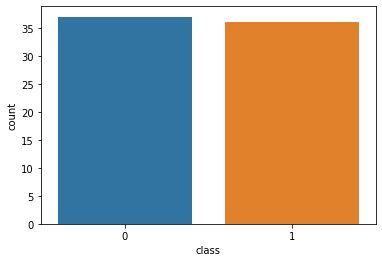

In [43]:
sns.countplot(x='class',data=train_data)

In [44]:
# Define a scaler to normalize input
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

EPOCHS = 50
BATCH_SIZE = 4
LEARNING_RATE = 0.001

In [45]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [46]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1,drop_last=True)

In [47]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12., 6 * 2 angles of 
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1) # prevents overfit, play with this also, up to 0.5
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32) ##
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        # x = self.batchnorm1(x) ## test this after seed
        x = self.relu(self.layer_2(x))
        # x = self.batchnorm2(x) ## test this after seed #small dataset
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [49]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss() #
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [50]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [51]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.69214 | Acc: 52.778
Epoch 002: | Loss: 0.66635 | Acc: 65.278
Epoch 003: | Loss: 0.65240 | Acc: 65.278
Epoch 004: | Loss: 0.62743 | Acc: 79.167
Epoch 005: | Loss: 0.60101 | Acc: 77.778
Epoch 006: | Loss: 0.56349 | Acc: 77.778
Epoch 007: | Loss: 0.52136 | Acc: 81.944
Epoch 008: | Loss: 0.48437 | Acc: 84.722
Epoch 009: | Loss: 0.46606 | Acc: 81.944
Epoch 010: | Loss: 0.42657 | Acc: 80.556
Epoch 011: | Loss: 0.39481 | Acc: 81.944
Epoch 012: | Loss: 0.37469 | Acc: 83.333
Epoch 013: | Loss: 0.35630 | Acc: 84.722
Epoch 014: | Loss: 0.34278 | Acc: 86.111
Epoch 015: | Loss: 0.32767 | Acc: 83.333
Epoch 016: | Loss: 0.30391 | Acc: 88.889
Epoch 017: | Loss: 0.30123 | Acc: 87.500
Epoch 018: | Loss: 0.29221 | Acc: 87.500
Epoch 019: | Loss: 0.27270 | Acc: 88.889
Epoch 020: | Loss: 0.24361 | Acc: 90.278
Epoch 021: | Loss: 0.25316 | Acc: 90.278
Epoch 022: | Loss: 0.23533 | Acc: 91.667
Epoch 023: | Loss: 0.22899 | Acc: 91.667
Epoch 024: | Loss: 0.23652 | Acc: 90.278
Epoch 025: | Los

In [75]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred) ##
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

files_names = list(pd.read_csv('mean_variance_test.csv')['file'])

file_predict_dict = {}
for i in range(len(y_pred_list)):
  file_predict_dict[files_names[i]] = y_pred_list[i]

print(file_predict_dict)

{'Bad 1.mov': 0.0, 'Bad 10.mov': 0.0, 'Bad 11.mov': 0.0, 'Bad 12.mov': 0.0, 'Bad 13.mov': 1.0, 'Bad 14.mov': 1.0, 'Bad 15.mov': 1.0, 'Bad 16.mov': 1.0, 'Bad 2.mov': 0.0, 'Bad 3.mov': 1.0, 'Bad 4.mov': 1.0, 'Bad 5.mov': 0.0, 'Bad 6.mov': 0.0, 'Bad 7.mov': 0.0, 'Bad 8.mov': 0.0, 'Bad 9.mov': 0.0, 'Good 1.mov': 1.0, 'Good 11.mov': 0.0, 'Good 12.mov': 1.0, 'Good 2.mov': 1.0, 'Good 4.mov': 1.0, 'Good 6.mov': 1.0, 'Good 7.mov': 1.0, 'Good 8.mov': 1.0, 'Good 9.mov': 1.0}


In [65]:
print(confusion_matrix(y_test, y_pred_list))
print(y_test)
print(y_pred_list)
print(classification_report(y_test, y_pred_list))

[[10  6]
 [ 1  8]]
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
Name: class, dtype: int64
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.57      0.89      0.70         9

    accuracy                           0.72        25
   macro avg       0.74      0.76      0.72        25
weighted avg       0.79      0.72      0.72        25



In [89]:
## prediction of Shoulder Press or Bicep Curl 

bc_test_video_dir = 'Good 2.mov'
sp_test_video_dir = 'SP good 1.mov'

test_frames,video,prob,label = sequence_prediction(2,bc_test_video_dir)


  bicep_curl: 50.69%
  shoulder_press: 49.31%


In [78]:
## prediction of good or bad

good_bad_predictor = file_predict_dict[bc_test_video_dir]
if good_bad_predictor == 1:
  label_2 = 'good'
else:
  label_2 = 'bad'

print(prob,label,label_2)

0.50694805 bicep_curl good


In [88]:
## Writing the output to the video itself for example sake 

import cv2

cap = cv2.VideoCapture(f'./gdrive/MyDrive/data/goodtest/{bc_test_video_dir}')
out = cv2.VideoWriter(f'./{video}', -1, 20.0, (640,480))
  
(grabbed, frame) = cap.read()
fshape = frame.shape
fheight = fshape[0]
fwidth = fshape[1]
print(fwidth , fheight)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (fwidth,fheight))

while(True):
      
    # Capture frames in the video
    ret, frame = cap.read()
  
    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    text_to_display = f'This is a {label} exercise with {prob}% probability\n this is also an example of a {label_2} {label}'
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame, 
                text_to_display, 
                (50, 50), 
                font, 1, 
                (0, 255, 255), 
                2, 
                cv2.LINE_4)
  
    # Display the resulting frame
    #cv2.imshow()
    out.write(frame)
  
    # creating 'q' as the quit 
    # button for the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()

2880 1800


KeyboardInterrupt: ignored